In [3]:
from numpy import *
import scipy
from scipy.sparse.linalg import eigsh
import librosa
import IPython.display as ipd
path = ""
filename = "testGGAAsample.wav"
from matplotlib.pylab import *
import scipy.io.wavfile
from scipy import signal

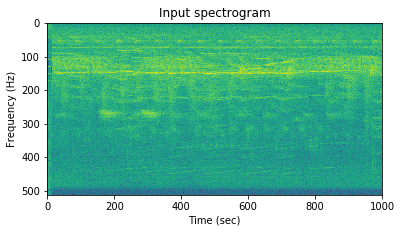

In [4]:
fs,s = scipy.io.wavfile.read(path + filename)

s = s.astype( float64)

# Get the magnitude spectrogram
q,t,f = signal.stft( s, fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
h = f
f = abs( f)
subplot( 1, 1, 1), pcolormesh( t[:1000], q, log(f[:,:1000])), title( 'Input spectrogram')
xlabel( 'Time (sec)'), ylabel( 'Frequency (Hz)')
plt.imshow(log(f[:,:1000]))



In [5]:
f.shape

(513, 21532)

In [6]:
def create_chunks(samples, framesPerChunk = 20):
    newMat = np.zeros((samples.shape[0] * framesPerChunk,1))
    chunked = []
    for colNum in range(0, np.shape(samples)[1], framesPerChunk):
        if (colNum + framesPerChunk > samples.shape[1]):
            break
        matrix = samples[:, colNum:colNum + framesPerChunk]
        matrix = matrix.flatten('F')
        matrix = np.reshape(matrix, (matrix.shape[0], 1))
        newMat = np.hstack((newMat, matrix))
    return newMat[:,1:]

In [7]:
def pca( x, k):
    # Remove data mean
    xm = x - mean( x, axis=1, keepdims=True)

    # Get covariance estimate
    C = xm.dot( xm.T) / (xm.shape[1]-1)

    # Get top k PCA covariance eigenvectors/values
    v,u = eigsh( C, k=k)

    # Get overall transform and the input's projection to k dimensions
    w = diag( 1./sqrt(v)) @ u.T
    y = w @ xm
    
    return w,y



In [8]:
from sklearn.decomposition import PCA
red_dims = 12
pca = PCA(n_components=red_dims)
chunk = create_chunks(f, 100)
#W,Z = pca(chunk, 10)
pca.fit(chunk.T) 
Z = pca.fit_transform(chunk.T).T
# Z.shape

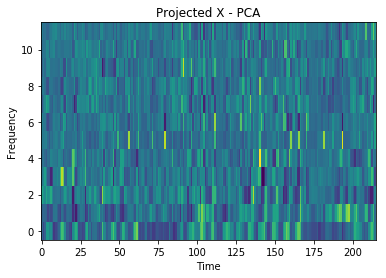

In [9]:
import matplotlib.pyplot as plot

fig_xhat = plot.figure()  
plot.title('Projected X - PCA')
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.imshow(Z, interpolation="none", origin='lower', aspect='auto')

In [10]:
def euclidean_dist(x1, x2):
    return np.sum((x1 - x2)**2)**0.5

def check_equality(x1, x2):
    if len(x1) != len(x2):
        return False
    for i in range(2):
        if np.array_equal(x1[i], x2[i]) == False:
            return False
    return True

def kmeans(initialization, Z, noOfClusters = 3, red_dims = 8):
    means = initialization
    iteration = 0
    prev = [np.zeros((red_dims,1)) for _ in range(noOfClusters)]
    while check_equality(means, prev) == False:
        prev = means
        collect = [np.zeros((red_dims,1)) for _ in range(noOfClusters)]
        labels = []
        for i in range(Z.shape[1]):
            e_dist = [euclidean_dist(Z[:,i].flatten('F').reshape((red_dims,1)), means[j]) for j in range(noOfClusters)]
            k = sorted(range(noOfClusters), key = lambda k: e_dist[k])[0]
            labels += [k]
            collect[k] += Z[:, i].flatten('F').reshape((red_dims,1))
        count = [0 for _ in range(noOfClusters)]
        for i in labels:
            count[i] += 1
        means = [collect[k]/count[k] for k in range(noOfClusters)]
        iteration += 1
    return iteration, means, labels

In [16]:
# GMM

def normal_dist(x, mu, covar):
    n = x.shape[0]
    red_mean = x - mu
    covar_det = np.linalg.det(covar)
    covar_inv = np.linalg.pinv(covar)
    pdf = ((1/((((2*np.pi)**(n)) * covar_det)**0.5)) * np.exp(-0.5 * ((red_mean.T @ covar_inv) @ red_mean )))
    return pdf[0][0]

def likelihood(Z, pi, cov, mean, noOfClusters = 3, red_dims = 20):
    value = 0
    for i in range(Z.shape[1]):
        x = Z[:, i].flatten('F').reshape((red_dims, 1))
        val = 0
        for j in range(noOfClusters):
            val += pi[j] * normal_dist(x, mean[j], cov[j])
        value += np.log(val + 10e-20)
    return value

def gmm_em(initialization, Z, noOfClusters = 3, red_dims = 8):
    pi = initialization['pi']
    cov = initialization['cov']
    mean = initialization['mean']
    prev, iteration = 0, 0
    loglike = likelihood(Z, pi, cov, mean, noOfClusters, red_dims)
    print(iteration, ":", prev, loglike)
        
    while np.abs(prev - loglike) > 1e-12:
        prev = loglike
        
        # Expectation step
        gamma = []
        for i in range(Z.shape[1]):
            x = Z[:, i].flatten('F').reshape((red_dims, 1))
            temp = []
            temp_sum = 0
            for j in range(noOfClusters):
                t1 = pi[j] * normal_dist(x, mean[j], cov[j])
                temp += [t1]
                temp_sum += t1
            gamma += [[k/temp_sum for k in temp]]
            
        # Maximization step
        pi_temp, mean_temp = [0 for _ in range(noOfClusters)], [np.zeros((red_dims, 1)) for _ in range(noOfClusters)]
        cov_temp = [np.zeros((red_dims, red_dims)) for _ in range(noOfClusters)]
        for i in range(Z.shape[1]):
            x = Z[:, i].flatten('F').reshape((red_dims, 1))
            for j in range(noOfClusters):
                pi_temp[j] += gamma[i][j]
                mean_temp[j] += gamma[i][j] * x
                cov_temp[j] += gamma[i][j] * ((x - mean[j]) @ (x - mean[j]).T)
        pi = [pi_temp[k]/Z.shape[1] for k in range(noOfClusters)]
        new_mean = [mean_temp[k]/pi_temp[k] for k in range(noOfClusters)]
        cov = [cov_temp[k]/pi_temp[k] for k in range(noOfClusters)]
        mean = new_mean
        iteration += 1
        loglike = likelihood(Z, pi, cov, mean, noOfClusters, red_dims)
        print(iteration, ":", prev, loglike)
        
   
    labels = []
    for i in range(Z.shape[1]):
        x = Z[:, i].flatten('F').reshape((red_dims, 1))
        sortStuff = [normal_dist(x, mean[k], cov[k]) for k in range(noOfClusters)]
        labels += [sorted(range(noOfClusters), key = lambda k: sortStuff[k], reverse = True)[0]]
    return iteration, labels

In [17]:
Z.shape

(12, 215)

In [18]:
red_dims = 12
noOfClusters = 4
# K-Means initialization
from random import randint
means = [Z[:, randint(0, Z.shape[1] - 1)].reshape((red_dims, 1)) for _ in range(noOfClusters)]
len(means)


4

In [19]:

iterations_kmeans, means_kmeans, labels_kmeans = kmeans(means, Z, noOfClusters, red_dims)
# check_accuracy(labels_kmeans)

#---------------------------------

# GMM clustering initialization
#count = [0 for _ in range(noOfClusters)]
#for i in labels_kmeans:
#    count[i] += 1
cov_l = [np.cov(Z) for _ in range(noOfClusters)]
'''
for i, l in enumerate(labels_kmeans):
    x1 = Z[:, i].flatten('F').reshape((red_dims, 1))
    cov_l[l] += ((x1 - means_kmeans[l]) @ (x1 - means_kmeans[l]).T)
cov = [cov_l[k]/(count[k] + 10e-5) for k in range(noOfClusters)]
'''
initial = {'pi' : [1/noOfClusters for _ in range(noOfClusters)], 'cov' : cov_l, 'mean' : means}

iterations_gmm, labels_gmm = gmm_em(initial, Z, noOfClusters, red_dims)
# # check_accuracy(labels_gmm)
print(iterations_kmeans, iterations_gmm)

0 : 0 -9406.060104880666
1 : -9406.060104880666 -9406.060104880666
6 1


In [80]:
data_kmeans = [np.zeros((513, 1)) for _ in range(noOfClusters)]
count_kmeans = [0 for _ in range(noOfClusters)]

for i in labels_kmeans:
    #print(labels_kmeans[i], i*30/1000)
    data_kmeans[i] = np.hstack((data_kmeans[i], h[:, i*100:i*100 + 100]))
    count_kmeans[i] += 1

data_gmm = [np.zeros((513, 1)) for _ in range(noOfClusters)]
count_gmm = [0 for _ in range(noOfClusters)]

for i in labels_gmm:
    data_gmm[i] = np.hstack((data_gmm[i], h[:, i*100:i*100 + 100]))
    count_gmm[i] += 1

In [81]:
print(count)
print(firstCluster_frames.shape, secondCluster_frames.shape, thirdCluster_frames.shape)

[128, 74, 13]
(513, 12801) (513, 7401) (513, 1301)


In [82]:
_, xrec = signal.istft( firstCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
scipy.io.wavfile.write("firstCluster_kmeans.wav",fs,xrec)
_, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
scipy.io.wavfile.write("secondCluster_kmeans.wav",fs,xrec)
_, xrec = signal.istft( thirdCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
scipy.io.wavfile.write("thirdCluster_kmeans.wav",fs,xrec)

128

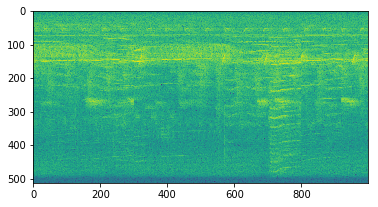

In [83]:
plt.imshow(log(abs(firstCluster_frames[:,1:1000])))
#np.hstack(firstCluster_frames[:,1:9600], thirdCluster_frames[:,1:1600])
first

74

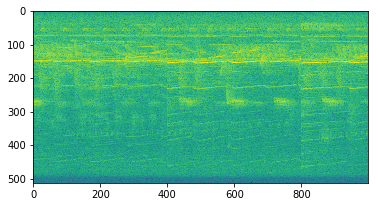

In [84]:
plt.imshow(log(abs(secondCluster_frames[:,1:1000])))
second

13

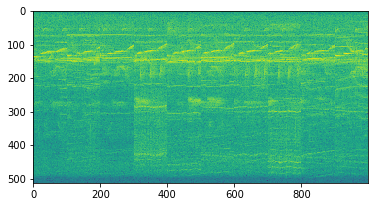

In [85]:
plt.imshow(log(abs(thirdCluster_frames[:,1:1000])))
third

# GMM Clustering

In [51]:
first =0 
second =0
third = 0
import pandas as pd
data = []
firstCluster_frames = np.zeros((513, 1))
secondCluster_frames = np.zeros((513, 1))
thirdCluster_frames = np.zeros((513, 1))

for i in range(len(labels_gmm)):
    #print(labels_kmeans[i], i*30/1000)
    if labels_gmm[i] == 0:
        first +=1
        firstCluster_frames = np.hstack((firstCluster_frames, h[:, i*100:i*100 + 100]))
        
    elif labels_gmm[i] == 1:
        second+=1
        secondCluster_frames = np.hstack((secondCluster_frames, h[:, i*100:i*100 + 100]))
    
    else:
        third += 1
        thirdCluster_frames = np.hstack((thirdCluster_frames, h[:, i*100:i*100 + 100]))







In [52]:
_, xrec = signal.istft( firstCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
scipy.io.wavfile.write("firstCluster.wav",fs,xrec)
_, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
scipy.io.wavfile.write("secondCluster_gmm.wav",fs,xrec)
_, xrec = signal.istft( thirdCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
scipy.io.wavfile.write("thirdCluster_gmm.wav",fs,xrec)

100

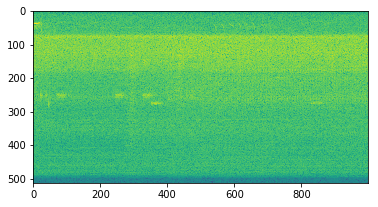

In [55]:
# _, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)

plt.imshow(log(abs(firstCluster_frames[:,1:1000])))
first

142

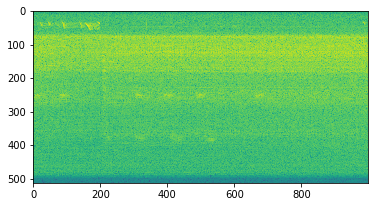

In [56]:
plt.imshow(log(abs(secondCluster_frames[:,1:1000])))
second

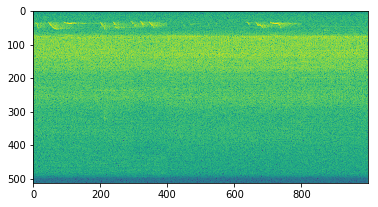

In [57]:
plt.imshow(log(abs(thirdCluster_frames[:,1:1000])))

In [24]:
birds/(noise + birds)

NameError: name 'birds' is not defined

In [25]:
%store secondCluster_frames
%store firstCluster_frames

Stored 'secondCluster_frames' (ndarray)
Stored 'firstCluster_frames' (ndarray)
